### Importing Libraries and Data

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import sklearn.metrics as sm
import seaborn as sns
import re
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [98]:
df = pd.read_csv('../website_classification.csv')
df.head(5)

,website_url,cleaned_website_text,Category
0,https://www.fubo.tv/lp/StreamTV/?irad=343747&i...,stream live tv sports fubotv free trial sport ...,Streaming Services
1,https://www.hulu.com/,stream tv movie live online hulu watch tv show...,Streaming Services
2,https://tv.youtube.com/,youtube tv watch dvr live sports shows news st...,Streaming Services
3,https://www.attwatchtv.com/,watchtv stream channel live tv want watchtv ex...,Streaming Services
4,https://www.klowdtv.com/,live tv streaming klowdtv klowdtv provide live...,Streaming Services


In [99]:
df.info() #checking if there is any Nan or null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1139 entries, 0 to 1138
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   website_url           1139 non-null   object
 1   cleaned_website_text  1139 non-null   object
 2   Category              1139 non-null   object
dtypes: object(3)
memory usage: 26.8+ KB


In [100]:
df["Category"].value_counts()

Computers and Technology           303
Social Networking and Messaging    114
Business/Corporate                 107
Streaming Services                 103
Sports                             100
E-Commerce                         100
Games                               99
News                                93
Law and Government                  83
Adult                               21
Forums                              16
Name: Category, dtype: int64

### Visualising distribution of website categories

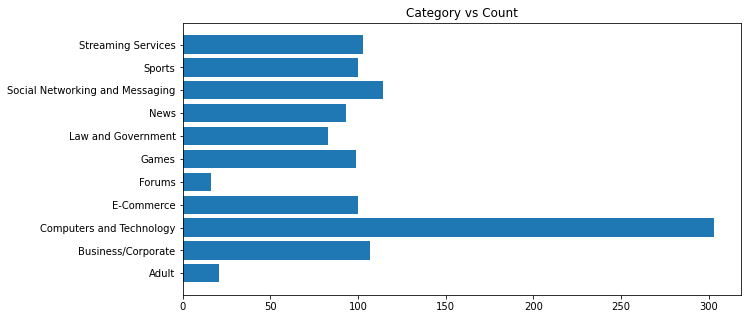

In [101]:
#visualising the count of each category
plt.figure(figsize=(10,5))
plt.title("Category vs Count")
site_category_count = pd.DataFrame(df.groupby(df['Category']).size(),columns=['Count'])
plt.barh(width=site_category_count['Count'],y=site_category_count.index)
plt.show()

In [102]:
site_category_count.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, Adult to Streaming Services
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Count   11 non-null     int64
dtypes: int64(1)
memory usage: 176.0+ bytes


In [103]:
print("Different categories of websites: ",len(site_category_count["Count"]))

Different categories of websites:  11


### Data Cleaning & Engineering

##### NLP pipeline
##### 1. Text processing
######    - Cleaning
######    - Normalization (changing to lowercase and removing punctuation)
######    - Word Tokenisation
######    - Remove stop words
######    - Remove Non-alpha text
######    - Word Stemming and Lemmatization

##### 2. Feature Engineering
######    - Label Encoding for Categories
######    - Bag of Words (CountVectorizer)
######    - TF-IDF (Bag of Words + Tf-IDF = TfidfVectorizer)
######    - Word Embeddings (word2vec/glove)

##### 3. Feature Selection

Normalizing text: convert to lowercase and remove punctuation

In [104]:
df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: x.lower())
df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: re.sub(r'[^\w\s]','',x))
df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: re.sub(r'\d+','',x))
df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: re.sub(r'\s+',' ',x))

In [105]:
df.head()

,website_url,cleaned_website_text,Category
0,https://www.fubo.tv/lp/StreamTV/?irad=343747&i...,stream live tv sports fubotv free trial sport ...,Streaming Services
1,https://www.hulu.com/,stream tv movie live online hulu watch tv show...,Streaming Services
2,https://tv.youtube.com/,youtube tv watch dvr live sports shows news st...,Streaming Services
3,https://www.attwatchtv.com/,watchtv stream channel live tv want watchtv ex...,Streaming Services
4,https://www.klowdtv.com/,live tv streaming klowdtv klowdtv provide live...,Streaming Services


Tokenising: Split sentence into list of words

In [106]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')
df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: word_tokenize(x))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User01\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Removing Stopwords

In [107]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: [word for word in x if word not in stop_words])
df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: [word for word in x if len(word)>2])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User01\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Word Stemming and Lemmatization

In [108]:
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
lem = WordNetLemmatizer()

def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:
        return 'n'
    
#Define function to lemmatize each word with its POS tag
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text)
    pos_tagged_text = [(word, pos_tagger(pos_tag)) for word, pos_tag in pos_tagged_text]
    return [lem.lemmatize(word, pos_tag) for word, pos_tag in pos_tagged_text]

df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: lemmatize_words(x))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User01\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [109]:
#joining tokenized words
df['cleaned_website_text'] = df['cleaned_website_text'].apply(lambda x: ' '.join(x))

Feature extraction: Label Encoding

In [110]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Category'] = le.fit_transform(df['Category'])

In [111]:
df.head()

,website_url,cleaned_website_text,Category
0,https://www.fubo.tv/lp/StreamTV/?irad=343747&i...,stream live sport fubotv free trial sport depo...,10
1,https://www.hulu.com/,stream movie live online hulu watch show movie...,10
2,https://tv.youtube.com/,youtube watch dvr live sport show news stream ...,10
3,https://www.attwatchtv.com/,watchtv stream channel live want watchtv extra...,10
4,https://www.klowdtv.com/,live stream klowdtv klowdtv provide live strea...,10


In [112]:
#splitting data into train and test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df['cleaned_website_text'],df['Category'],test_size=0.2,random_state=42)

In [113]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((911,), (228,), (911,), (228,))

Feature extraction: Tf-idf vectorizer

In [114]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_id_vectorizer = TfidfVectorizer(analyzer='word',smooth_idf=True,max_features=5000)
tf_id_train = tf_id_vectorizer.fit_transform(X_train)
tf_id_test = tf_id_vectorizer.transform(X_test)

In [115]:
feature_names = tf_id_vectorizer.get_feature_names_out()

#get IDF score
idf_score = tf_id_vectorizer.idf_

# Print feature names and IDF scores
for feature, score in zip(feature_names, idf_score):
    print(feature, score)

aaron 5.107589788972121
abc 5.107589788972121
abigail 5.869729841019018
ability 3.672505263682799
able 3.304780483557481
abra 6.206202077640231
abroad 5.04305126783455
absence 5.736198448394496
absolutely 4.178053830347945
abu 4.871201010907891
abuse 4.152078343944686
academic 4.448344160087857
academy 4.448344160087857
acc 5.618415412738112
acca 7.1224928095143865
accelerate 4.519803124070002
accept 3.1242921078451875
acceptance 4.9252682321781664
access 2.2901870509425475
accessibility 3.3270036203421918
accessible 4.260291928584918
accessorie 4.871201010907891
accessory 3.552960113033016
accident 5.417744717275961
accord 3.5251805489259405
account 2.1457590670938114
accountant 5.513054897080286
accounting 5.107589788972121
accuracy 4.771117552350908
accurate 4.28927946545817
accurately 5.176582660459073
accuse 4.819907716520341
ace 4.771117552350908
achieve 3.772588722239781
achievement 4.724597536716015
acknowledge 4.771117552350908
acm 6.0238805208462765
acquire 4.519803124070002


Model training

In [116]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have your training data (X_train) and corresponding labels (y_train)

# Define the models and their respective hyperparameters to try during grid search
models = {
    'MNB': {
        'model': MultinomialNB(),
        'params': {
            'mnb__alpha': [0.1, 0.5, 1.0, 1.5, 2.0]
        }
    },
    'SVM': {
        'model': SVC(),
        'params': {
            'svm__C': [1, 10],
            'svm__kernel': ['linear', 'rbf']
        }
    },
}

# Perform grid search and cross-validation for each model
for model_name, model_data in models.items():
    print("Evaluating:", model_name)
    
    # Create a pipeline with a TF-IDF vectorizer and the current model
    pipeline = Pipeline([
        ("feature_selection", SelectKBest(score_func=chi2)),
        (model_name.lower(), model_data['model'])
    ])
    
    # Define the hyperparameters for the current model
    parameters = {
        'feature_selection__k':[1000, 2000, 3000, 4000, 5000],
        **model_data['params']
    }
    
    # Perform grid search with 5-fold cross-validation
    grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='accuracy')
    grid_search.fit(tf_id_train, y_train)
    
    # Get the best model and its corresponding hyperparameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Make predictions on the test set
    y_pred = best_model.predict(tf_id_test)
    
    # Calculate and print evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print("Best parameters:", best_params)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 score:", f1)
    print("----------------------------------")

Evaluating: MNB


c:\Users\User01\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'feature_selection__k': 5000, 'mnb__alpha': 0.1}
Accuracy: 0.9210526315789473
Precision: 0.9097280257034263
Recall: 0.9210526315789473
F1 score: 0.9118212971198375
----------------------------------
Evaluating: SVM
Best parameters: {'feature_selection__k': 4000, 'svm__C': 10, 'svm__kernel': 'linear'}
Accuracy: 0.9122807017543859
Precision: 0.9085825858505914
Recall: 0.9122807017543859
F1 score: 0.9068208240891094
----------------------------------


In [117]:
from sklearn.feature_selection import chi2
chi2_selector = SelectKBest(score_func=chi2, k=5000)

X_train_selected = chi2_selector.fit_transform(tf_id_train, y_train)
X_test_selected = chi2_selector.transform(tf_id_test)

In [118]:
model = MultinomialNB(alpha=0.1)
model.fit(X_train_selected,y_train)

MultinomialNB(alpha=0.1)

In [119]:
import sklearn.metrics as sm

y_pred = model.predict(X_test_selected)
print(f'The accuracy of train model is {sm.accuracy_score(y_train,model.predict(X_train_selected))}')
print(f'The accuracy of test model is {sm.accuracy_score(y_test,y_pred)}')

The accuracy of train model is 0.9802414928649835
The accuracy of test model is 0.9210526315789473


In [121]:
from bs4 import BeautifulSoup
import bs4 as bs4
from urllib.parse import urlparse
import requests
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import os


class ScrapTool:   
    def visit_url(self,website_url):
        '''
        Visit URL. Download the Content. Initialize the beautifulsoup object. Call parsing methods. Return Series object.
        '''
        #Set up Selenium webdriver
        PATH = 'C:/Users/User01/Downloads/chromedriver_win32/chromedriver.exe'

        # Set the Chrome webdriver options
        chrome_options = Options()
        chrome_options.add_argument("--headless")
        # Initialize the Chrome webdriver and pass the Chrome options
        service = Service(PATH)
        driver = webdriver.Chrome(service = service, options = chrome_options)

        #Load website
        driver.get(website_url)
        
        # Check if the cookie consent button is present
        cookie_button = None
        try:
            cookie_button = WebDriverWait(driver, 15).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "cookie-consent-button")))
        except:
            pass

        # Handle cookies if the button is present
        if cookie_button:
            cookie_button.click()

        # Extract HTML content
        html_content = driver.page_source
        driver.quit()

        soup = BeautifulSoup(html_content,'lxml')
        result = {
            "website_url": website_url,
            "website_name": self.get_website_name(website_url),
            "website_text": self.get_html_title_tag(soup)+self.get_html_meta_tags(soup)+self.get_html_heading_tags(soup)+
                                    self.get_text_content(soup)
        }
        
        #Convert to Series object and return
        return pd.Series(result)
    
    def get_website_name(self,website_url):
        '''
        Example: returns "google" from "www.google.com"
        '''
        return "".join(urlparse(website_url).netloc.split(".")[-2])
    
    def get_html_title_tag(self,soup):
        '''Return the text content of <title> tag from a webpage'''
        return '. '.join(soup.title.contents)
    
    def get_html_meta_tags(self,soup):
        '''Returns the text content of <meta> tags related to keywords and description from a webpage'''
        tags = soup.find_all(lambda tag: (tag.name=="meta") & (tag.has_attr('name') & (tag.has_attr('content'))))
        content = [str(tag["content"]) for tag in tags if tag["name"] in ['keywords','description']]
        return ' '.join(content)
    
    def get_html_heading_tags(self,soup):
        '''returns the text content of heading tags. The assumption is that headings might contain relatively important text.'''
        tags = soup.find_all(["h1","h2","h3","h4","h5","h6"])
        content = [" ".join(tag.stripped_strings) for tag in tags]
        return ' '.join(content)
    
    def get_text_content(self,soup):
        '''returns the text content of the whole page with some exception to tags. See tags_to_ignore.'''
        tags_to_ignore = ['style', 'script', 'head', 'title', 'meta', '[document]',"h1","h2","h3","h4","h5","h6","noscript"]
        tags = soup.find_all(text=True)
        result = []
        for tag in tags:
            stripped_tag = tag.strip()
            if tag.parent.name not in tags_to_ignore\
                and isinstance(tag, bs4.element.Comment)==False\
                and not stripped_tag.isnumeric()\
                and len(stripped_tag)>0:
                result.append(stripped_tag)
        return ' '.join(result)

In [122]:
#cleaning text and preprocessing
def cleaning_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r'\d+','',text)   
    text = word_tokenize(text)
    text = [word for word in text if word not in stop_words]
    text = [word for word in text if len(word)>2]
    text = lemmatize_words(text)
    text = ' '.join(text)
    vector = tf_id_vectorizer.transform([text])
    vector = chi2_selector.transform(vector)
    vector = vector.toarray()
    return vector

In [123]:
def website_prediction(website,model):
    scrapTool = ScrapTool()
    try:
        web = dict(scrapTool.visit_url(website))
        text = cleaning_text(web['website_text'])
        prediction = model.predict(text)
        print(f'The website is under the category of {le.inverse_transform(prediction)[0]}')
    except:
        print("Connection Timeout")

In [124]:
import pickle

filename = 'RootModel.sav'
pickle.dump(model, open(filename, 'wb'))

#loading the model
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(tf_id_test, y_test)
print(result)

0.9210526315789473


              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.86      0.95      0.90        20
           2       0.98      0.84      0.91        63
           3       1.00      0.92      0.96        13
           4       0.00      0.00      0.00         0
           5       0.95      1.00      0.97        19
           6       1.00      0.96      0.98        23
           7       0.92      0.96      0.94        24
           8       0.76      0.95      0.84        20
           9       1.00      0.89      0.94        18
          10       1.00      0.96      0.98        26

    accuracy                           0.92       228
   macro avg       0.83      0.86      0.84       228
weighted avg       0.95      0.92      0.93       228



c:\Users\User01\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User01\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User01\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

<AxesSubplot:>

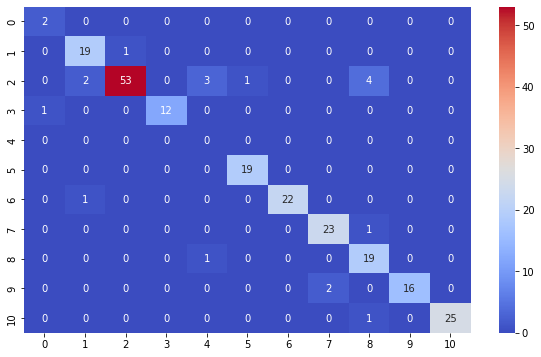

In [125]:
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report

plt.figure(figsize=(10,6))
predictions = model.predict(tf_id_test)
print(classification_report(predictions,y_test))
sns.heatmap(confusion_matrix(predictions,y_test),cmap='coolwarm',annot=True)

In [126]:
pd.set_option('display.max_rows', None)
predictions = model.predict(X_test_selected)
results = pd.DataFrame({'Cleaned Text':X_test,'Actual':y_test,'Predicted':predictions})
results[(results['Actual']==2) & (results['Actual']!=results['Predicted'])]

,Cleaned Text,Actual,Predicted
723,webonthefly web content management custom deve...,2,1


In [127]:
df.iloc[723]

website_url                                       http://webonthefly.com/
cleaned_website_text    webonthefly web content management custom deve...
Category                                                                2
Name: 723, dtype: object